In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.stats import poisson

### Poisson Random Variables

In [2]:
pBackup = dict()
def poisson(x, lam):
    global pBackup
    key = x * 10 + lam
    if key not in pBackup.keys():
        pBackup[key] = np.exp(-lam) * pow(lam, x) / np.math.factorial(x)
    return pBackup[key]

### Markov Decision Process

In [3]:
POISSON_UPPER_BOUND = 11
COST_OF_MOVING = 2
MAX_CARS = 20
MAX_MOVE_OF_CARS = 5
EXPECTED_FIRST_LOC_REQUESTS = 3
EXPECTED_FIRST_LOC_RETURNS = 3
EXPECTED_SECOND_LOC_REQUESTS = 4
EXPECTED_SECOND_LOC_RETURNS = 2
DISCOUNT_RATE = 0.9
RENTAL_CREDIT = 10
EXTRA_PARKING_COST = 4

## EXAMPLE

In [4]:
def expectedReturn(state, action, stateValues):
    returns = 0
    # if action > 0 :
    #     action -= 1
    returns += - np.abs(action)*COST_OF_MOVING

    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))

    # if carsLoc1 > 10:
    #     returns -= EXTRA_PARKING_COST
    # if carsLoc2 > 10:
    #     returns -= EXTRA_PARKING_COST
    
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS)*poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT

            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    returnsProb = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS)*poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS)
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    returns += rentalsProb*returnsProb*(rewards + DISCOUNT_RATE*stateValues[carsLoc1_prime, carsLoc2_prime])
    return returns  

In [5]:
states = []
for i in range(MAX_CARS+1):
    for j in range(MAX_CARS+1):
        states.append([i, j])

## Policy Iteration

In [6]:
stateValues = np.zeros((MAX_CARS+1, MAX_CARS+1))
gamma = 0.9
delta = 0.1

actions = [0, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5]

# Deterministic Policy
pi = stateValues.copy()

for iter in tqdm(range(4)):
    # Evaluating pi
    newStateValues = stateValues.copy()
    while True:
        for i, j in states:
            state = [i, j]
            newStateValues[i, j] = expectedReturn(state, pi[i, j], stateValues)
        if np.abs(stateValues- newStateValues).max() <= delta:
            # State Values converged for this policy
            break
        stateValues = newStateValues.copy()
        
    # Improving pi
    pi_stable = True
    for i, j in states:
        
        state = [i, j]
        old_action = pi[i, j]
        old_Val = stateValues[i, j]
        
        for action in actions:
            new_Val = expectedReturn(state, action, stateValues)
            if new_Val > old_Val and action != old_action:
                pi[i, j] = action
                pi_stable = False
                old_Val = new_Val


  0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
# Maximum Return with Policy with no car moves: 549
# Maximum Return with 5th Policy : 592
# Maximum Return with 5th Policy according to new dynamics : 550
stateValues.max()

616.086281474945

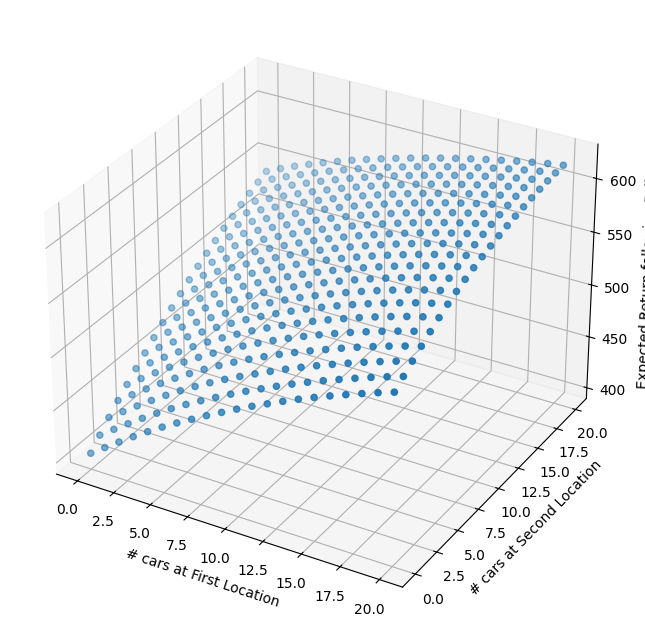

In [8]:
fig, ax = plt.subplots(1, 1, subplot_kw = {"projection": "3d"}, figsize=(8, 8))
ax.set_xlabel("# cars at First Location")
ax.set_ylabel("# cars at Second Location")
ax.set_zlabel("Expected Return following Policy pi")
x = np.arange(21)
y = np.arange(21)
x, y = np.meshgrid(x, y)
ax.scatter(x, y, stateValues)

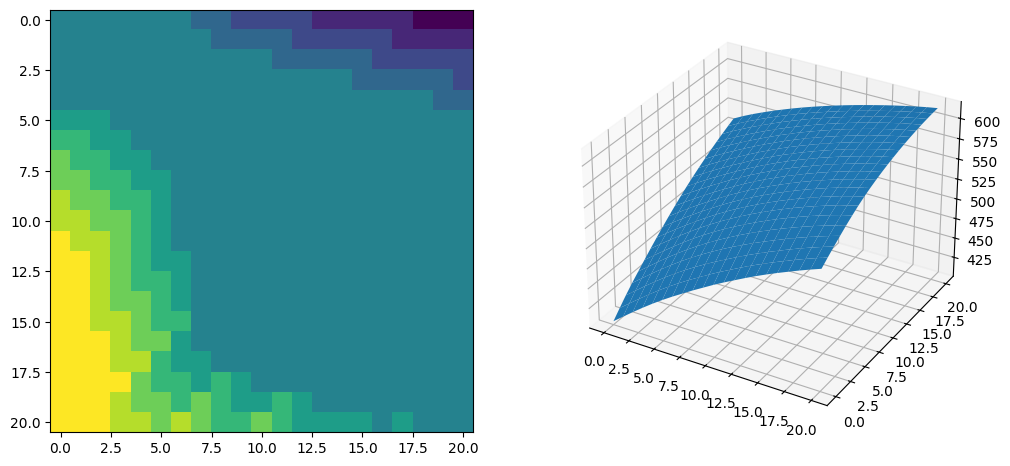

In [9]:
# Plotting pi
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.imshow(pi)
# ax.
ax = fig.add_subplot(122, projection="3d")
x = np.arange(21)
y = np.arange(21)
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, stateValues)

## Exercise

In [10]:
def expectedReturn(state, action, stateValues):
    returns = 0
    if action > 0 :
        action -= 1
    returns += - np.abs(action)*COST_OF_MOVING

    carsLoc1 = int(min(state[0] - action, MAX_CARS))
    carsLoc2 = int(min(state[1] + action, MAX_CARS))

    if carsLoc1 > 10:
        returns -= EXTRA_PARKING_COST
    if carsLoc2 > 10:
        returns -= EXTRA_PARKING_COST
    
    for rentalsLoc1 in range(0, POISSON_UPPER_BOUND):
        for rentalsLoc2 in range(0, POISSON_UPPER_BOUND):
            rentalsProb = poisson(rentalsLoc1, EXPECTED_FIRST_LOC_REQUESTS)*poisson(rentalsLoc2, EXPECTED_SECOND_LOC_REQUESTS)
            totalRentalsLoc1 = min(carsLoc1, rentalsLoc1)
            totalRentalsLoc2 = min(carsLoc2, rentalsLoc2)
            rewards = (totalRentalsLoc1 + totalRentalsLoc2) * RENTAL_CREDIT

            for returnsLoc1 in range(0, POISSON_UPPER_BOUND):
                for returnsLoc2 in range(0, POISSON_UPPER_BOUND):
                    returnsProb = poisson(returnsLoc1, EXPECTED_FIRST_LOC_RETURNS)*poisson(returnsLoc2, EXPECTED_SECOND_LOC_RETURNS)
                    carsLoc1_prime = min(carsLoc1 - totalRentalsLoc1 + returnsLoc1, MAX_CARS)
                    carsLoc2_prime = min(carsLoc2 - totalRentalsLoc2 + returnsLoc2, MAX_CARS)
                    returns += rentalsProb*returnsProb*(rewards + DISCOUNT_RATE*stateValues[carsLoc1_prime, carsLoc2_prime])
    return returns  

In [11]:
stateValues = np.zeros((MAX_CARS+1, MAX_CARS+1))
gamma = 0.9
delta = 0.1

actions = [0, 1, 2, 3, 4, 5, -1, -2, -3, -4, -5]

# Deterministic Policy
pi = stateValues.copy()

for iter in tqdm(range(4)):
    # Evaluating pi
    newStateValues = stateValues.copy()
    while True:
        for i, j in states:
            state = [i, j]
            newStateValues[i, j] = expectedReturn(state, pi[i, j], stateValues)
        if np.abs(stateValues- newStateValues).max() <= delta:
            # State Values converged for this policy
            break
        stateValues = newStateValues.copy()
        
    # Improving pi
    pi_stable = True
    for i, j in states:
        
        state = [i, j]
        old_action = pi[i, j]
        old_Val = stateValues[i, j]
        
        for action in actions:
            new_Val = expectedReturn(state, action, stateValues)
            if new_Val > old_Val and action != old_action:
                pi[i, j] = action
                pi_stable = False
                old_Val = new_Val


  0%|          | 0/4 [00:00<?, ?it/s]

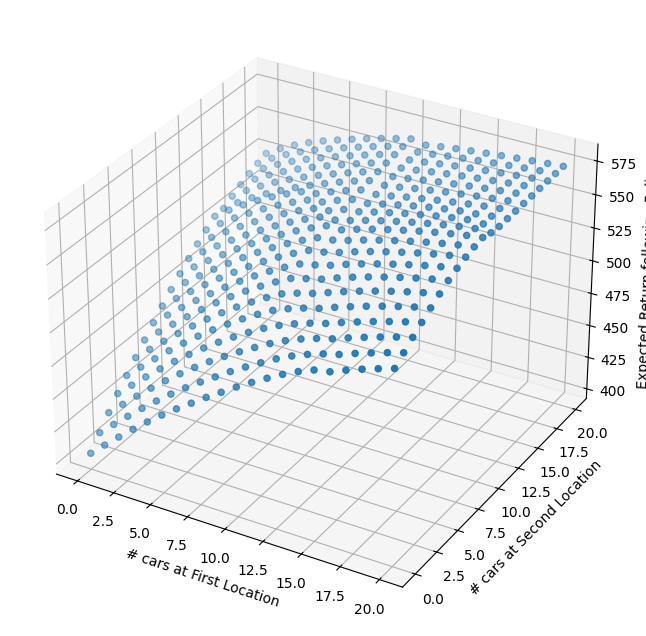

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw = {"projection": "3d"}, figsize=(8, 8))
ax.set_xlabel("# cars at First Location")
ax.set_ylabel("# cars at Second Location")
ax.set_zlabel("Expected Return following Policy pi")
x = np.arange(21)
y = np.arange(21)
x, y = np.meshgrid(x, y)
ax.scatter(x, y, stateValues)

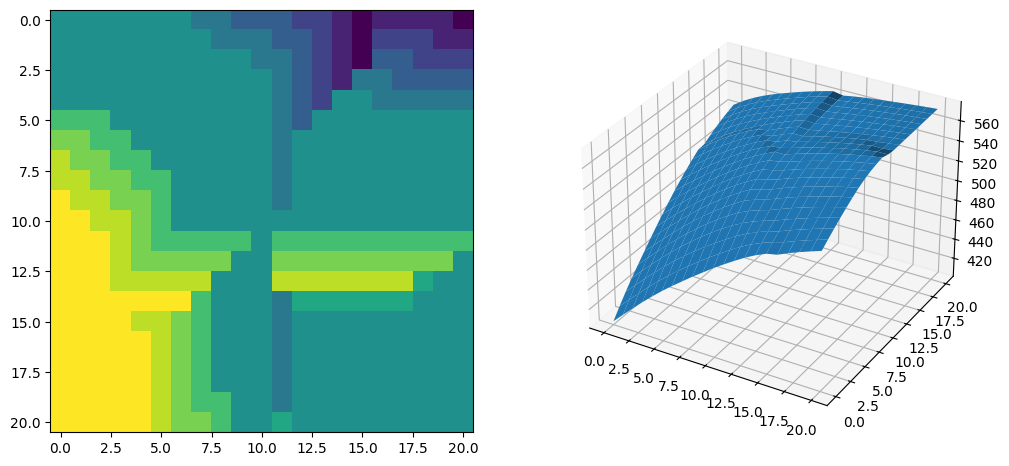

In [13]:
# Plotting pi
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.imshow(pi)
# ax.
ax = fig.add_subplot(122, projection="3d")
x = np.arange(21)
y = np.arange(21)
x, y = np.meshgrid(x, y)
ax.plot_surface(x, y, stateValues)